Before reading this Jupyter Notebook, it may be helpful to review [spherical and cylindrical coordinates](Spherical_Cylindrical_Coordinates.ipynb) and the concept of a [midplane](Midplane.ipynb).

# Physical Properties of Synestias

You'll notice that synestias are very large planetary objects. The synestias shown here and throughout the notebooks are Earth-mass synestias. Their widths span about 200,000 km (124,000 miles) across -- that's almost 16 Earths (or 2,000,000 soccer fields)!

The synestia shown in this chapter was formed as a result of a potential-Moon-forming giant impact (see B.1 Synestia Case 1 in [Synestia_Moon_Ex_Cases.ipynb](Synestia_Moon_Ex_Cases.ipynb)). Giant impacts deposit enough energy into the impacted material to vaporize rock. In a giant impact between two impactors with a total mass equal to that of Earth, the heat energy ([Carter et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JE006042)) is comparable to the amount of energy required to power a house for every inhabitant on Earth for the next 70 billion years ([U.S. Energy Information Administration, 2015](https://www.eia.gov/consumption/residential/data/2015/c&e/pdf/ce1.1.pdf)). Synestias have a large (10-20\% of total mass) vapor component which makes them very hot, extended and flared.

## Temperature Profile of a Synestia
What does "very hot" mean? What is the hottest phenomena you can think of and how does it compare to the maximum temperature within the interior of the Earth-mass synestia in the temperature plots below? What are the temperature ranges for each portion of this synestia (e.g. disk-like, mantle, and core)? How does temperature change between the planet-disk and core-mantle boundaries?
 
### How to Use These Interactive Plots
You may have to be patient while the plots load. If there is output but no images, re-run the notebook. If the plots do not load after 1-2 minutes, restart the notebook.

Use the sliders to explore the thermal structure of a synestia via spatial slices of various parameter profiles (temperature, pressure, and density): the middle value (0) on both sliders is a slice of the profile at the center the synestia. The slider values indicate the distance from the center of the synestia (higher values = greater distance from the center). The sign indicates the direction from the center. Positive distance from the rotational axis (+y) is closer to the observer while negative distance from the rotational axis (-y) is farther away from the observer (other side of the center). Distance from the midplane is positive (+z) when the slice is at the top of the synestia and negative (-z) when the slice is at the bottom. The 3D orientation of the slice (cross-section of a synestia) is shown to the right. The rotational axis lies along the line where x = 0 and y = 0, and the midplane is a plane at z = 0. There are two plots with different views of the example synestia: side (slice is a y plane; midplane appears as a line at z = 0) and bird's eye (slice is a z plane; looking down along the rotational axis which is a point x = 0, y = 0 at the center).

As you slide back and forth, notice when your slice enters the disk-like region (no planet-disk boundary shown on plot as black, dashed ellipse) versus the planet-like region. The dashed, black line indicates the boundary between the planet-like region and the disk-like region (where the planet-like region is interior to the planet-disk boundary). When your slice cuts through the planet-like region, you should be able to notice when your slice only cuts through the mantle (no core-mantle boundary shown on plot in red). The solid red line indicates the boundary between the mantle and core within the planet-like region (where the core is interior to the core-mantle boundary).

The plots shown in this notebook use data output from giant impact simulations, which model continuous fluids in synestias using particles with fixed mass but varying size and density to approximate reality. It's easier to get a sense of the whole structure when looking at how the individual particles behave. Think of these particles as having volume -- like a blob of gas. The overlap between particles is smoothed to accommodate tremendous density differences between the particles, hence the name for this type of computer modeling, <i>smoothed-particle hydrodynamics</i> (SPH).

### Temperatures in an Earth-mass Synestia

```{margin} Running a code cell
Access interactive features by 'Launch CoLab' or 'Launch Binder' from the rocket logo at the top of the page. When the interactive environment is ready, place your cursor in the code cell and press shift-return to execute the code. CoLab launches more quickly.
```
Click the + symbol to see the code that generates the next interactive feature.

In [ ]:
# Dear Reader, if you are using this notebook in CoLab, you need to fetch a few files from github
# uncomment the lines below and shift-return to execute this cell

#import os
#os.system('wget https://github.com/ststewart/synestiabook2/tree/master/synestia-book/docs/TE_Example03_Cool01_snapshot_10500_long')
#os.system('wget https://github.com/ststewart/synestiabook2/tree/master/synestia-book/docs/TE_Example01_Cool05_snapshot_4096_long')

In [12]:
# STSM modified to remove use of module syndef and embed necessary functions into this cell
# from syndef import synfits

import numpy as np
import struct
import urllib.request
G=6.674e-11 #SI


class GadgetHeader:
    """Class for Gadget snapshot header."""
    def __init__(self, t=0, nfiles=1, ent=1):
        self.npart = np.zeros(6)
        self.mass = np.zeros(6)
        self.time = t
        self.redshift = 0
        self.flag_sfr = 0
        self.flagfeedbacktp = 0
        self.npartTotal = np.zeros(6)
        self.flag_cooling = 0
        self.num_files = nfiles
        self.BoxSize = 0
        self.Omega0 = 0
        self.OmegaLambda = 0
        self.HubbleParam = 1
        self.flag_stellarage = 0
        self.flag_metals = 0
        self.nallhw = np.zeros(6)
        self.flag_entr_ics = ent
#
class Snapshot:
    """Gadget snapshot class
    Includes header and gas particle data, with functions for reading and writing snapshots.
    load() -- load Gadget snapshot data
    remove() -- remove particle from snapshot
    write() -- save snapshot
    identify() -- determine material types
    calc_vap_frac() -- calculate vapour fractions of particles
    #GOH 01/15/2020
    -- fit midplane density profile
    -- fit midplane entropy profile
    -- fit midplane pressure profile
    -- fit midplane temperature profile
    -- fit midplane velocity profile
    -- fit midplane sound speed profile
    -- fit scale height for density
    -- fit scale height for entropy
    -- fit scale height for pressure
    -- fit scale height for temperature
    -- fit scale height for velocity profile
    -- fit scale height for sound speed profile
    """
    def __init__(self):
        self.header = GadgetHeader()
        self.N = 0
        self.pos = np.zeros(3)
        self.vel = np.zeros(3)
        self.id = 0
        self.m = 0
        self.S = 0
        self.rho = 0
        self.hsml = 0
        self.pot = 0
        self.P = 0
        self.T = 0
        self.U = 0
        self.cs = 0
        #self.accel = 0
        #self.dt = 0
        #self.vapfrac = 0
        self.omg_z = 0
        self.J2Ma2 = 0
        self.g = 0
        self.ind_outer_mid_spl = 0
        self.pmidfit = 0
        self.rhomidfit = 0,0,0
#
    def load(self, fname, thermo=False):
        f = open(fname, 'rb')
        struct.unpack('i', f.read(4))
        #HEADER
        self.header.npart = np.array(struct.unpack('iiiiii', f.read(24)))
        self.header.mass = np.array(struct.unpack('dddddd', f.read(48)))
        (self.header.time, self.header.redshift, self.header.flag_sfr,
         self.header.flag_feedbacktp) = struct.unpack('ddii', f.read(24))
        self.header.npartTotal = np.array(struct.unpack('iiiiii', f.read(24)))
        (self.header.flag_cooling, self.header.num_files, self.header.Boxsize,
         self.header.Omega0, self.header.OmegaLambda, self.header.HubbleParam,
         self.header.flag_stellarage,
         self.flag_metals) = struct.unpack('iiddddii', f.read(48))
        #print(self.header.Boxsize,self.header.flag_stellarage,self.flag_metals)
        self.header.nallhw = np.array(struct.unpack('iiiiii', f.read(24)))
        self.header.flag_entr_ics = struct.unpack('i', f.read(4))
        struct.unpack('60x', f.read(60))
        struct.unpack('i', f.read(4))
        if self.header.num_files != 1:
            print("WARNING! Number of files:", self.header.num_files,
                  ", not currently supported.\n")
        self.N = self.header.npart[0]
        count=str(self.N)
        count3=str(3*self.N)
        #PARTICLE DATA
        struct.unpack('i', f.read(4))
        self.pos = struct.unpack(count3 + 'f', f.read(3*self.N*4))
        struct.unpack('i', f.read(4))
        struct.unpack('i', f.read(4))
        self.vel = struct.unpack(count3 + 'f', f.read(3*self.N*4))
        struct.unpack('i', f.read(4))
        struct.unpack('i', f.read(4))
        self.id = np.array(struct.unpack(count + 'i', f.read(self.N*4)))
        struct.unpack('i', f.read(4))
        struct.unpack('i', f.read(4))
        self.m = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
        struct.unpack('i', f.read(4))
        struct.unpack('i', f.read(4))
        self.S = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
        struct.unpack('i', f.read(4))
        struct.unpack('i', f.read(4))
        self.rho = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
        struct.unpack('i', f.read(4))
        struct.unpack('i', f.read(4))
        self.hsml = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
        struct.unpack('i', f.read(4))
        struct.unpack('i', f.read(4))
        self.pot = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
        struct.unpack('i', f.read(4))
        if thermo:
            struct.unpack('i', f.read(4))
            self.P = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
            struct.unpack('i', f.read(4))
            struct.unpack('i', f.read(4))
            self.T = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
            struct.unpack('i', f.read(4))
            if len(f.read(4)) == 4:
                self.U = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
                struct.unpack('i', f.read(4))
            if len(f.read(4)) == 4:
                self.cs = np.array(struct.unpack(count + 'f', f.read(self.N*4)))
                struct.unpack('i', f.read(4))
        f.close()
        #REARRANGE
        self.pos = np.array(self.pos).reshape((self.N, 3))*(1e-2) #m
        self.x = self.pos.T[0]
        self.y = self.pos.T[1]
        self.z = self.pos.T[2]
        self.vel = np.array(self.vel).reshape((self.N, 3))*(1e-2) #m/s
        self.vx = self.vel.T[0]
        self.vy = self.vel.T[1]
        self.vz = self.vel.T[2]
        #print("Read %d" % self.N, "particles from %s" % fname)
        #CALCULATE CENTER OF MASS
        N=25
        temp=np.argsort(self.pot)
        xcm=np.mean(self.x[temp[0:N]])
        ycm=np.mean(self.y[temp[0:N]])
        zcm=np.mean(self.z[temp[0:N]])
        vxcm=np.mean(self.vx[temp[0:N]])
        vycm=np.mean(self.vy[temp[0:N]])
        vzcm=np.mean(self.vz[temp[0:N]])
        #MOVE ONTO CENTRAL FRAME
        self.x=self.x-xcm
        self.y=self.y-ycm
        self.z=self.z-zcm
        self.vx=self.vx-vxcm
        self.vy=self.vy-vycm
        self.vz=self.vz-vzcm
        #CALCULATE BOUND MASS
        self.m = self.m*(1e-3) #kg
        #bndm=self.m[temp[0]]
        #G=6.67408E-11 #mks
        #oldm=bndm/10.
        #tol=1E-5
        #while (np.abs(oldm-bndm)>tol):
        #    oldm=bndm
        #    v2=np.add(np.add(np.power(self.vx,2.0),np.power(self.vy,2.0))np.power(self.vz,2.0))
        #    r=np.sqrt(np.add(np.add(np.power(self.x,2.0),np.power(self.y,2.0))np.power(self.z,2.0)))
        #    KE=0.5*np.multiply(self.m,v2)
        #    PE=-G*bndm*np.divide(self.m,r)
        #    bndm=np.sum(self.m[np.where((KE+PE)<0.)[0]])
        #CONVERT REST OF UNITS TO MKS
        self.rho = self.rho*(1e3) #kg/m3
        self.P = self.P*1e9 #Pa
        self.S = self.S*(1e-4) #J/K/kg
        self.pot = self.pot*(1e-4) #J/kg
        self.U = self.U*(1e-4) #J/kg
        self.cs = self.cs*(1e-2) #m/s
        self.rxy = np.add(np.power(self.x, 2), np.power(self.y, 2)) #m2
        radius2 = np.add(self.rxy,np.power(self.z,2)) #m2
        self.rxy = np.sqrt(self.rxy) #m
        self.omg_z = (self.vx**2 + self.vy**2)**0.5/self.rxy
        self.J2Ma2 = -np.sum(0.5*np.multiply(self.m,radius2)*(3.0*np.divide(np.power(self.z,2),radius2) - 1.0)) #kg m2
        self.g = np.zeros((self.N, 3))
        self.g_x = self.g.T[0]
        self.g_y = self.g.T[1]
        self.g_z = self.g.T[2]
        self.g_x = (G*np.sum(self.m)*self.x/((np.sqrt(self.rxy**2 + self.z**2))**3)) - (3.*G*self.J2Ma2*((self.rxy**2 + self.z**2)**-2.5)*self.x*(2.5*((self.z**2)/(self.rxy**2 + self.z**2)) - 1.5))
        self.g_y = (G*np.sum(self.m)*self.y/((np.sqrt(self.rxy**2 + self.z**2))**3)) - (3.*G*self.J2Ma2*((self.rxy**2 + self.z**2)**-2.5)*self.y*(2.5*((self.z**2)/(self.rxy**2 + self.z**2)) - 1.5))
        self.g_z = (G*np.sum(self.m)*self.z/((np.sqrt(self.rxy**2 + self.z**2))**3)) - (3.*G*self.J2Ma2*((self.rxy**2 + self.z**2)**-2.5)*self.z*(2.5*((self.z**2)/(self.rxy**2 + self.z**2)) - 1.5))
        #print("Centered bound mass.\n")
#
    def indices(self,zmid,zmax,rxymin,rxymax,rxymida,rxymidb):
        #DETERMINE OUTER REGION PARTICLES (truncated at rxymin and rxymax)
        self.ind_outer=np.where((self.rxy >= rxymin) & (self.rxy <= rxymax) & (np.abs(self.z) <= zmax))
        self.ind_outer_1=np.where((self.rxy >= rxymin) & (self.rxy < rxymida) & (np.abs(self.z) <= zmax))
        self.ind_outer_2=np.where((self.rxy > rxymidb) & (self.rxy <= rxymax) & (np.abs(self.z) <= zmax))
        self.ind_outer_S=np.where(self.rxy >= rxymin)

        #DETERMINE MIDPLANE OUTER REGION PARTICLES
        self.ind_outer_mid=np.where((self.rxy >= rxymida) & (np.abs(self.z) <= zmid) & (self.rxy <= rxymidb))
        self.ind_outer_mid_spl = np.where((np.abs(self.z) <= zmid) & (self.rxy <= rxymax) & (self.rxy >= rxymin))
        self.ind_outer_mid_lsq=np.where((np.abs(self.z) <= zmid) & (self.rxy >= 9.4e6))
        
        #DETERMINE MIDPLANE PARTICLES
        self.ind_mid=np.where(np.abs(self.z) <= zmid)
# 
    def fit_Pmid(self,knots,extra=None):
        #DETERMINE SPLINE FIT TO MIDPLANE PRESSURE CURVE
        ind_outer_mid_spl=np.where((np.abs(SNAP.z) <= zmid) & (SNAP.rxy <= rxymax) & (SNAP.rxy >= rxymin))
        indsort=np.argsort(SNAP.rxy[ind_outer_mid_spl])
        SPHrxyMm = SNAP.rxy[ind_outer_mid_spl][indsort]/1e6
        SPHplog = np.log10(SNAP.P[ind_outer_mid_spl][indsort])
        pknots=[*knots]
        self.pLSQUSPL = LSQUnivariateSpline(SPHrxyMm, SPHplog, t=pknots, k=3)
        if extra:
            print('knots for midplane pressure curve are rxy = {}'.format(pLSQUSPL.get_knots()))
            print('coefficients for midplane pressure curve are {}'.format(pLSQUSPL.get_coeffs()))
    
    def fit_rhomid(self,extra=None):
        #DETERMINE LEAST-SQUARES FIT TO RESIDUAL OF MIDPLANE RHO S-CURVE 1
        params_guess=np.ones(4)
        res_lsq = least_squares(resfunc, params_guess, loss='soft_l1', f_scale=0.001, 
                                args=(np.log10(self.rxy[self.ind_outer_2]/1e6), np.log10(self.rho[self.ind_outer_2])))
        
        #DETERMINE LEAST-SQUARES FIT TO RESIDUAL OF MIDPLANE RHO S-CURVE 2
        params_guess_spl=np.array([150.,1.4,16.,-5.7])
        res_lsq_spl = least_squares(resfuncspl, params_guess_spl, loss='soft_l1', f_scale=0.001, 
                                    args=(np.log10(self.rxy[self.ind_outer_mid]/1e6), np.log10(self.rho[self.ind_outer_mid])))
        
        #DETERMINE LEAST-SQUARES FIT TO RESIDUAL OF MIDPLANE RHO LINE
        params_guess_lin=np.ones(2)
        res_lsq_lin = least_squares(resfunclin, params_guess_lin, loss='soft_l1', f_scale=0.001,
                                    args=(np.log10(self.rxy[self.ind_outer_1]/1e6), np.log10(self.rho[self.ind_outer_1])))
        
        if extra:
            print('Least Squares Fit to Midplane Density - S-curve \n')
            print(res_lsq)
            print('\n Least Squares Fit to Midplane Density - Spline \n')
            print(res_lsq_spl)
            print('\n Least Squares Fit to Midplane Density - Linear \n')
            print(res_lsq_lin)
            print('\n Params for midplane density:\n fit 0 {}\n fit 1 {}\n fit 2 {}\n Linear interpolation points are (x1_lim, y1_lim) = ({}, {}) and (x2_lim, y2_lim) = ({}, {})'.format(res_lsq_lin.x,res_lsq_spl.x,res_lsq.x,x1int,y1int,x2int,y2int))
            
        self.rhomidfit = res_lsq_lin.x,res_lsq_spl.x,res_lsq.x
#        
    def fit_Tmid(self,extra=None):
        params_guess_T=np.asarray([4.e12,-1.66,2.5])
        res_lsq_pow = least_squares(resfuncpow, params_guess_T, ftol=1e-10, xtol=1e-11, loss='soft_l1',
                                    args=(SNAP.rxy[ind_outer_mid_lsq], SNAP.T[ind_outer_mid_lsq]/1.e3))
        if extra:
            print('\n Least Squares Fit to Midplane Temperature - Power Law \n')
            print(res_lsq_pow)
#        
    def fit_smid(self,extra=None):
        params_guess_S = np.ones(5)
        res_lsq_lp = least_squares(resfunclinpiece, params_guess_S, ftol=1e-8, xtol=1e-8, loss='soft_l1', 
                                   args=(SNAP.rxy[ind_outer_mid_spl]/1e6, SNAP.S[ind_outer_mid_spl]))
        if extra:
            print('\n Least Squares Fit to Midplane Entropy - Linear Piecewise \n')
            print(res_lsq_lp)
#            
    def fit_zs_rho(self,extra=None):
        #SCALE HEIGHT FIT
        #bin by rxy, fit each bin's rho(z) profile and find z where rho/rho_mid=1/e
        ind_outer_offmid = np.where((SNAP.rxy >= 7.e6) & (np.abs(SNAP.z) > 1.e6))
        bins = np.arange(7.e6,np.amax(SNAP.rxy[ind_outer_offmid])+1.e6,1.e6)
        #bins_S = np.arange(7.e6,np.amax(SNAP.rxy[ind_outer_S])+1.e6,1.e6)
        ind_bin = np.digitize(SNAP.rxy[ind_outer_offmid],bins,right=False)
        #ind_bin_S = np.digitize(SNAP.rxy[ind_outer_S],bins_S,right=False)
        bins=(bins/1e6)-0.5 #convert to Mm
        #bins_S=(bins_S/1e6)-0.5
        params_guess_exp = 1.
        #def resfuncpieceS(params,x,y,z):
            #x is rxy, y is z, z is S
        #    f1 = params[0]
        #    f2 = params[1]
        #    f3 = lambda y: params[2]*y**2 + params[3]*y + params[4]
        #    return np.select([(y>params[5]),(y<=params[5])*(y>=params[6]),(y<params[6])*(x<10.)], [f1,f2,f3]) - z
        #params_guess_Spiece = np.asarray([4500.,8000.,1.,1.,4000.,15.,1.])
        res_lsq_exp = []
        #res_lsq_Spiece = []
        for i in range(len(bins)):
            ind_rxy = np.where(ind_bin == i)
            SNAP_rhodiv_offmid = np.log(SNAP.rho[ind_outer_offmid][ind_rxy]*(
                10**(-piece(np.log10(SNAP.rxy[ind_outer_offmid][ind_rxy]/1.e6),res_lsq_lin.x,res_lsq_spl.x,res_lsq.x))))
            reslsqexp = least_squares(resfuncexp, params_guess_exp, bounds=(1,np.inf), loss='soft_l1', f_scale=0.001, 
                                      args=(np.abs(SNAP.z[ind_outer_offmid][ind_rxy]/1e6),SNAP_rhodiv_offmid))
            if reslsqexp.active_mask[0] == -1:
                res_lsq_exp.append(np.nan)
            else:
                res_lsq_exp.append(reslsqexp.x[0])
        #for i in range(len(bins_S)):
        #    ind_rxy_S = np.where(ind_bin_S == i)
        #    print(ind_rxy_S.active_mask)
        #    if ind_rxy_S.active_mask == -1:
        #        res_lsq_Spiece.append(np.nan)
        #    else:
        #        reslsqSpiece = least_squares(resfuncpieceS, params_guess_Spiece, loss='soft_l1', f_scale=0.001, args=(SNAP.rxy[ind_outer_S][ind_rxy_S]/1.e6,np.abs(SNAP.z[ind_outer_S][ind_rxy_S])/1e6,SNAP.S[ind_outer_S][ind_rxy_S]))
        #        res_lsq_Spiece.append(reslsqSpiece.x)

        res_lsq_exp = np.asarray(res_lsq_exp) #Mm
        #res_lsq_Spiece = np.asarray(res_lsq_Spiece)
        print('\n Binned Rxy Scale Height Fits')
        print(res_lsq_exp)
        #print(res_lsq_Spiece)

        #MASKING SCALE HEIGHT FITS FOR NAN'S AND Z_S > 100 Mm
        res_lsq_exp_mask = np.ma.fix_invalid(res_lsq_exp)
        res_lsq_exp_compress = res_lsq_exp_mask.compressed()
        bins_mask = np.ma.masked_array(bins, mask=res_lsq_exp_mask.mask)
        bins_compress = bins_mask.compressed()
        res_lsq_exp_compress_mask = np.ma.masked_greater(res_lsq_exp_compress,100.)
        res_lsq_exp_compress2 = res_lsq_exp_compress_mask.compressed()
        bins_compress_mask = np.ma.masked_array(bins_compress, mask=res_lsq_exp_compress_mask.mask)
        bins_compress2 = bins_compress_mask.compressed()
        print('\n Masked Rxy Scale Heights')
        print(zip(bins_compress2,res_lsq_exp_compress2))
        knots=[25.5,30.5,32.5,39.5,45.5,57.5]
        LSQUSPL=LSQUnivariateSpline(bins_compress2, res_lsq_exp_compress2, t=knots, k=3)
        if extra:
            bknot = LSQUSPL.get_knots()
            bcoef = LSQUSPL.get_coeffs()
            print('\n LSQ Univariate Spline Fit to Scale Heights \n')
            print('knots are rxy = {} (Mm)'.format(bknot))
            print('coefficients are {}'.format(bcoef))



SNAP_CukStewart=Snapshot()
SNAP_CukStewart.load('TE_Example03_Cool01_snapshot_10500_long',thermo=True) #Cuk & Stewart 2012 style giant impact




https://github.com/ststewart/synestiabook2/tree/master/synestia-book/docs/syndef/TE_Example03_Cool01_snapshot_10500_long
WARNING! Number of files: 1702064993 , not currently supported.



error: unpack requires a buffer of 13716344952 bytes

In [ ]:
#import numpy as np  # loaded above

from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact,FloatSlider,fixed
import warnings

warnings.catch_warnings()
warnings.simplefilter("ignore")

#define gridded arrays where want x,y,z points on plots
n = 256 #number of gridded points for xyz arrays
x_absmax = 30e6 #m
z_absmax = 20e6 #m

#semi-major and -minor axes of ellipsoid defining planetary boundaries
#planet-like region boundary with disk-like region
a_mantle = 10000. #km #a_mantle=b_mantle axisymmetric
c_mantle = 7000. #km
#core-mantle boundary within planet-like region
a_core = 3900. #km #a_core=b_core axisymmetric
c_core = 3500. #km

#assign particle information to single variable & convert units
# original gohollyday
#T_unfilt=synfits.SNAP_CukStewart.T #K
#x_unfilt=synfits.SNAP_CukStewart.x/1e3 #km
#y_unfilt=synfits.SNAP_CukStewart.y/1e3 #km
#z_unfilt=synfits.SNAP_CukStewart.z/1e3 #km
#S_unfilt=synfits.SNAP_CukStewart.S #J/K/kg
# stsm modified
T_unfilt=SNAP_CukStewart.T #K
x_unfilt=SNAP_CukStewart.x/1e3 #km
y_unfilt=SNAP_CukStewart.y/1e3 #km
z_unfilt=SNAP_CukStewart.z/1e3 #km
S_unfilt=SNAP_CukStewart.S #J/K/kg


filt=~((np.abs(z_unfilt)>30000.*(T_unfilt-5000.)**(-1./12.))&(T_unfilt>5000.))
T=T_unfilt[filt]
x=x_unfilt[filt]
y=y_unfilt[filt]
z=z_unfilt[filt]
S=S_unfilt[filt]

#sort data into kdtree
xyz = np.vstack((x,y,z)).transpose() #km
tree = cKDTree(xyz) #make tree, sort particles into leafs

#create x,y,z arrays and turn them into 2-D arrays
xarr = np.linspace(-x_absmax,x_absmax,n)/1e3 #km
zarr = np.linspace(-z_absmax,z_absmax,n)/1e3 #km
Xarr,Zarr = np.meshgrid(xarr,zarr) #km, km
yarr = np.linspace(-x_absmax,x_absmax,n)/1e3 #km
Xarr2,Yarr = np.meshgrid(xarr,yarr) #km, km

#function that gets nearest neighbor information for gridded points
#and plots their physical property (temperature) value using pcolormesh
#slice through synestia showing side view
def temperature_xz(yvalue,Xarr,Zarr,T):
    Yarr = np.ones_like(Xarr)*yvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    temp = T[ind].reshape(Xarr.shape)
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = (((18./11.)*T[indtest[:,0]] + (9./11.)*T[indtest[:,1]] + (6./11.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean

    #ellipses (surface of ellipsoids) defining planetary boundaries
    v = np.linspace(0.,2.*np.pi,80) #radians
    u_mantle = np.arcsin(yvalue/(a_mantle*np.sin(v))) #radians
    x_mantle = a_mantle*np.cos(u_mantle)*np.sin(v) #km
    z_mantle = c_mantle*np.cos(v) #km
    u_core = np.arcsin(yvalue/(a_core*np.sin(v))) #radians
    x_core = a_core*np.cos(u_core)*np.sin(v) #km
    z_core = c_core*np.cos(v) #km
    #u = np.linspace(0.,2.5*np.pi,25) #radians
    #x_ep = a_ep*np.cos(u)*np.sin(v) #km
    #y_ep = a_ep*np.sin(u)*np.sin(v) #km
    #z_ep = c_ep*np.cos(v) #km
    #y_ep2 = a_ep*np.sin(u)*np.sin(v2) #km
    #X_ep_temp, Y_ep_temp = np.meshgrid(x_ep, y_ep) #km
    #Z_ep_temp = c_ep*(1. - (X_ep_temp**2)/(a_ep**2) - (Y_ep_temp**2)/(b_ep**2))**0.5 #km
    #X_ep = np.tile(X_ep_temp, 2)
    #Y_ep = np.tile(Y_ep_temp, 2)
    #Z_ep = np.tile(Z_ep_temp, 2)
    #zlen = np.shape(Z_ep_temp)[0]
    #Z_ep[:,zlen:] *= -1
    
    #arrays for plane showing slice through synestia in 3D
    xarr = np.linspace(-30000,30000,3) #km
    zarr = np.linspace(-20000,20000,3) #km
    xarr2d, zarr2d = np.meshgrid(xarr, zarr) #km
    yarr2d = np.ones_like(xarr2d)*yvalue #km
    
    fig = plt.figure(figsize=(13.5,5))
    ax = fig.add_subplot(121)
    plt.title('Temperature Profile: Side View')
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    ax.set_aspect(aspect=1, adjustable='box', anchor='C') 
    plt.pcolormesh(Xarr,Zarr,temp,vmin=np.amin(T),vmax=15000)
    #plt.pcolormesh(Xarr,Zarr,temp_k,vmin=np.amin(T),vmax=15000)
    plt.colorbar(label='temperature (K)')
    plt.plot(x_mantle,z_mantle,ls='--',lw=2,color='k',label='Planet-Disk')
    plt.plot(x_core,z_core,lw=2,color='r',label='Core-Mantle')
    plt.legend(loc=3)
    
    ax2 = fig.add_subplot(122, projection='3d')
    plt.title('Position of Slice in 3D')
    ax2.plot_surface(xarr2d, yarr2d, zarr2d)
    #ax2.plot(x_mantle,z_mantle,zs=yvalue,zdir='y',color='white')
    #ax2.plot(x_core,z_core,zs=yvalue,zdir='y',color='r')
    plt.xlabel('x (km)')
    plt.xlim([-30000, 30000])
    ax2.tick_params(axis='x', labelsize=8)
    plt.ylabel('y (km)')
    plt.ylim([-30000, 30000])
    ax2.tick_params(axis='y', labelsize=8)
    ax2.set_zlabel('z (km)')
    ax2.set_zlim(-20000, 20000)
    ax2.tick_params(axis='z', labelsize=8)
    plt.show()
    plt.close()
    
#function that gets nearest neighbor information for gridded points
#and plots their physical property (temperature) value using pcolormesh
#slice through synestia showing bird's eye view    
def temperature_xy(zvalue,Xarr,Yarr,T):
    warnings.catch_warnings()
    warnings.simplefilter("ignore") #hide warning for clipped (not real) pressure values
    Zarr = np.ones_like(Xarr)*zvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    temp = T[ind].reshape(Xarr.shape)

    #ellipses (surface of ellipsoids) defining planetary boundaries
    u = np.linspace(0.,2.*np.pi,80) #radians
    v_mantle = np.arccos(zvalue/c_mantle) #radians
    x_mantle = a_mantle*np.cos(u)*np.sin(v_mantle) #km
    y_mantle = a_mantle*np.sin(u)*np.sin(v_mantle) #km
    v_core = np.arccos(zvalue/c_core) #radians
    x_core = a_core*np.cos(u)*np.sin(v_core) #km
    y_core = a_core*np.sin(u)*np.sin(v_core) #km
    
    #arrays for plane showing slice through synestia in 3D
    xarr = np.linspace(-30000,30000,3)
    yarr = np.linspace(-30000,30000,3)
    xarr2d, yarr2d = np.meshgrid(xarr, yarr)
    zarr2d = np.ones_like(xarr2d)*zvalue
    
    fig = plt.figure(figsize=(13.5,5))
    ax = fig.add_subplot(121)
    plt.title('Temperature Profile: Bird\'s Eye View')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Yarr,temp,vmin=np.amin(T),vmax=15000)
    plt.colorbar(label='temperature (K)')
    plt.plot(x_mantle,y_mantle,ls='--',lw=2,color='k',label='Planet-Disk')
    plt.plot(x_core,y_core,lw=2,color='r',label='Core-Mantle')
    plt.legend(loc=3)
    
    ax2 = fig.add_subplot(122, projection='3d')
    plt.title('Position of Slice in 3D')
    ax2.plot_surface(xarr2d, yarr2d, zarr2d)
    plt.xlabel('x (km)')
    plt.xlim([-30000, 30000])
    ax2.tick_params(axis='x', labelsize=8)
    plt.ylabel('y (km)')
    plt.ylim([-30000, 30000])
    ax2.tick_params(axis='y', labelsize=8)
    ax2.set_zlabel('z (km)')
    ax2.set_zlim(-20000, 20000)
    ax2.tick_params(axis='z', labelsize=8)
    plt.show()
    plt.close()

style = {'description_width': 'initial'}
layout = {'width': '400px'}
interact(temperature_xz,yvalue = FloatSlider(value=0, min=-30e3, max=30e3, step=2e3, description='Distance from Rotational Axis (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr), Zarr=fixed(Zarr), T=fixed(T)
        )
interact(temperature_xy,zvalue = FloatSlider(value=0, min=-20e3, max=20e3, step=2e3, description='Distance from Midplane (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr2), Yarr=fixed(Yarr), T=fixed(T)
        )



<i>Caption</i>. Temperatures are high everywhere in a synestia. The minimum temperature is 2,000 K, but temperatures are as high as 15,000 K. Set the distances to zero. The outer yellow temperature contour (x = 10,000 km) represents the transition between the disk-like region and the planet-like region. The layers of the planet-like region, from the center outwards, are inner core (green, x $<$ 3,000 km), outer core (yellow, 3,000 km $<$ x $<$ 4,000 km), lower mantle (blue-purple, 4,000 km $<$ x $<$ 5,000 km), and upper mantle (green, 5,000 km $<$ x $<$ 10,000 km). The upper mantle and outer core are much hotter than their adjacent interior layers (lower mantle and inner core, respectively).

"Very hot" is pretty darn hot! If teleportation is ever discovered, don't ask to be sent into a synestia. There is no solid surface upon which we could stand, but if we somehow were floating in the moon-forming region of a synestia, it would feel like a (burning) hot, heavy atmospheric blanket. Imagine a volcanic eruption, but 2 to 15 times hotter.

The temperature profile of a synestia is different from that of a planet.

A planet, Earth for example, is mostly a solid body, and so temperature increases with depth towards the center of the planet. Pressure also increases with depth in a planet. If a planet can be approximated by a series of nested spherical shells (or layers) with a given mass, then the weight of the outer layers presses the inner layers towards the center of the body. The core is at the highest pressures because it has the most layers on top. Thus, as pressures increase, so must temperature.

In contrast, a synestia has multiple temperature inversions in the planet-like region where temperature decreases with depth in the mantle then sharply increases where the core (iron) meets the mantle (silicate). Both iron and silicate in a synestia's planet-like region are in their liquid phases and can be redistributed within the interior. Since iron is denser than silicate, the iron settles into a sphere at the center of the body under the influence of gravity. The silicate liquid forms a layer on top of the iron. Under the influence of gravity, the colder, denser liquid silicate and iron in the mantle and the core, respectively, settle to deeper depths while the hotter, less dense liquid buoys up to shallower depths. In the plot above, the outermost yellow ring indicates hot vapor (like an atmosphere) against the boundary of the mantle, while the innermost yellow ring marks the outer core. This is most easily seen when the distances are set to zero.

## Pressure Profile of a Synestia

Synestias are flared due to the large volume of gas in their disk-like regions. As a result, pressures in the moon-forming region are higher than expected for an equivalent traditional planet-disk system. What are the pressures at the moon-forming region (r$_{xy}$ = 20,000 km, z = 0 km) in the Earth-mass synestia in the pressure plots below? What is the range of pressures in the disk-like region in this Earth-mass synestia? How does it compare to Earth's present-day atmosphere? Do you notice a difference in the magnitude of pressures in the disk-like region versus the planet-like region?

Click the + symbol to see the code that generates the next interactive feature.

In [3]:
#do same thing for pressure
#P=synfits.SNAP_CukStewart.P #Pa
P=SNAP_CukStewart.P #Pa


#function that gets nearest neighbor information for gridded points
#and plots their physical property (pressure) value using pcolormesh
#slice through synestia showing side view
def pressure_xz(yvalue,Xarr,Zarr,P):
#yvalue,Xarr,Zarr are in km; P is in Pa
    Yarr = np.ones_like(Xarr)*yvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    press = np.log10(P[ind].reshape(Xarr.shape)/101325.) #atm

    #ellipses (surface of ellipsoid) defining planetary boundaries
    v = np.linspace(0.,2.*np.pi,80) #radians
    u_mantle = np.arcsin(yvalue/(a_mantle*np.sin(v))) #radians
    x_mantle = a_mantle*np.cos(u_mantle)*np.sin(v) #km
    z_mantle = c_mantle*np.cos(v) #km
    u_core = np.arcsin(yvalue/(a_core*np.sin(v))) #radians
    x_core = a_core*np.cos(u_core)*np.sin(v) #km
    z_core = c_core*np.cos(v) #km
    
    #arrays for plane showing slice through synestia in 3D
    xarr = np.linspace(-30000,30000,3)
    zarr = np.linspace(-20000,20000,3)
    xarr2d, zarr2d = np.meshgrid(xarr, zarr)
    yarr2d = np.ones_like(xarr2d)*yvalue
    
    fig = plt.figure(figsize=(13.5,5))
    ax = fig.add_subplot(121)
    plt.title('Pressure Profile: Side View')
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    ax.set_aspect(aspect=1, adjustable='box', anchor='C')
    plt.pcolormesh(Xarr,Zarr,press,vmin=np.amin(np.log10(P/101325.)),vmax=np.amax(np.log10(P/101325.)))
    plt.colorbar(label='log$_{10}$(pressure) (atm)')
    plt.plot(x_mantle,z_mantle,ls='--',lw=2,color='k',label='Planet-Disk')
    plt.plot(x_core,z_core,lw=2,color='r',label='Core-Mantle')
    plt.legend(loc=3)
    
    ax2 = fig.add_subplot(122, projection='3d')
    plt.title('Position of Slice in 3D')
    ax2.plot_surface(xarr2d, yarr2d, zarr2d)
    plt.xlabel('x (km)')
    plt.xlim([-30000, 30000])
    ax2.tick_params(axis='x', labelsize=8)
    plt.ylabel('y (km)')
    plt.ylim([-30000, 30000])
    ax2.tick_params(axis='y', labelsize=8)
    ax2.set_zlabel('z (km)')
    ax2.set_zlim(-20000, 20000)
    ax2.tick_params(axis='z', labelsize=8)
    #ax2.dist = 10.5
    plt.show()
    plt.close()

#function that gets nearest neighbor information for gridded points
#and plots their physical property (pressure) value using pcolormesh
#slice through synestia showing bird's eye view
def pressure_xy(zvalue,Xarr,Yarr,P):
#zvalue,Xarr,Yarr are in km; P is in Pa
    Zarr = np.ones_like(Xarr)*zvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    press = np.log10(P[ind].reshape(Xarr.shape)/101325.) #atm

    #ellipses (surface of ellipsoids) defining planetary boundaries
    u = np.linspace(0.,2.*np.pi,80) #radians
    v_mantle = np.arccos(zvalue/c_mantle) #radians
    x_mantle = a_mantle*np.cos(u)*np.sin(v_mantle) #km
    y_mantle = a_mantle*np.sin(u)*np.sin(v_mantle) #km
    v_core = np.arccos(zvalue/c_core) #radians
    x_core = a_core*np.cos(u)*np.sin(v_core) #km
    y_core = a_core*np.sin(u)*np.sin(v_core) #km
    
    #arrays for plane showing slice through synestia in 3D
    xarr = np.linspace(-30000,30000,3)
    yarr = np.linspace(-30000,30000,3)
    xarr2d, yarr2d = np.meshgrid(xarr, yarr)
    zarr2d = np.ones_like(xarr2d)*zvalue
    
    fig = plt.figure(figsize=(13.5,5))
    ax = fig.add_subplot(121)
    plt.title('Pressure Profile: Bird\'s Eye View')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Yarr,press,vmin=np.amin(np.log10(P/101325.)),vmax=np.amax(np.log10(P/101325.)))
    plt.colorbar(label='log$_{10}$(pressure) (atm)')
    plt.plot(x_mantle,y_mantle,ls='--',lw=2,color='k',label='Planet-Disk')
    plt.plot(x_core,y_core,lw=2,color='r',label='Core-Mantle')
    plt.legend(loc=3)
    
    ax2 = fig.add_subplot(122, projection='3d')
    plt.title('Position of Slice in 3D')
    ax2.plot_surface(xarr2d, yarr2d, zarr2d)
    plt.xlabel('x (km)')
    plt.xlim([-30000, 30000])
    ax2.tick_params(axis='x', labelsize=8)
    plt.ylabel('y (km)')
    plt.ylim([-30000, 30000])
    ax2.tick_params(axis='y', labelsize=8)
    ax2.set_zlabel('z (km)')
    ax2.set_zlim(-20000, 20000)
    ax2.tick_params(axis='z', labelsize=8)
    plt.show()
    plt.close()

interact(pressure_xz,yvalue = FloatSlider(value=0, min=-30e3, max=30e3, step=2e3, description='Distance from Rotational Axis (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr), Zarr=fixed(Zarr), P=fixed(P)
        )
interact(pressure_xy,zvalue = FloatSlider(value=0, min=-20e3, max=20e3, step=2e3, description='Distance from Midplane (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr2), Yarr=fixed(Yarr), P=fixed(P)
        )

interactive(children=(FloatSlider(value=0.0, description='Distance from Rotational Axis (km)', layout=Layout(w…

interactive(children=(FloatSlider(value=0.0, description='Distance from Midplane (km)', layout=Layout(width='4…

<function __main__.pressure_xy(zvalue, Xarr, Yarr, P)>

<i>Caption</i>. Pressures tend to be higher along the midplane and near the center of the body (x, y, z) = (0, 0, 0). There is high pressure (100 atm) gas at large radii in the midplane (e.g. the moon-forming region). Extremely high pressures (10$^4$ to 10$^6$ atm) exist in the planet-like region while a more broad range of pressures (10$^{-4}$ to 10$^4$) exists in the disk-like region.

Our atmosphere is 1 atm, so imagine how it would feel to have the weight of 10's or 100's of Earth's atmosphere surrounding you! That is what the pressure of gas in a synestia's moon-forming region would feel like.
        
If you have ever been swimming, the pressure you feel (most noticeably in your ears) at a depth of 10 meters (33 feet) of water is 2 atm. The pressure felt by a synestia's vapor in its moon-forming region will be at least five times that. For the synestia in the pressure plots above, the pressure at the boundary of the moon-forming region is 100 atm, but it can be as low as 10 atm for other synestias.

In the mantle of this synestia, the pressure can be about 10$^4$ atm, give or take an order of magnitude. In the core of a synestia, pressures range from 10$^5$ atm to 10$^6$ atm. That's a tremendous amount of pressure! 

The high pressures in a synestia are the reason why gas has such an effect on the dynamics within a synestia. Pressure acts as an additional significant force that allows a synestia to be very flared and large and emplaces more material in the moon-forming region than a traditional moon-forming disk. High pressures also facilitate chemical equilibration of material (making rocky material in a synestia as "homogeneous" as possible) from which the moon can form. There is a dynamic range of pressures in a synestia. In this case, the pressures range anywhere from 0.0001 atm (essentially leaking out into vacuum of space) to millions of atm (core).

## Density Profile of a Synestia

Now that you have an idea of how heavy a synestia's gas would feel, how thick would the gas be in various parts of a synestia (e.g. disk-like region, mantle, and core)? In other words, how dense would it be? For comparison, under standard conditions (at sea level and 15$^{\circ}$C), our air's density is 1.225 kg/m$^3$, liquid water on Earth has a density of about 1,000 kg/m$^3$, and solid iron has a density of about 10,000 kg/m$^3$.

Click the + symbol to see the code that generates the next interactive feature.

In [4]:
#do same thing for density
#rho=synfits.SNAP_CukStewart.rho #kg/m^3
rho=SNAP_CukStewart.rho #kg/m^3


#function that gets nearest neighbor information for gridded points
#and plots their physical property (density) value using pcolormesh
#slice through synestia showing side view
def density_xz(yvalue,Xarr,Zarr,rho):
#yvalue,Xarr,Zarr are in km; rho is in kg/m^3
    Yarr = np.ones_like(Xarr)*yvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    dens = np.log10(rho[ind].reshape(Xarr.shape)) #kg/m^3

    #ellipses (surface of ellipsoid) defining planetary boundaries
    v = np.linspace(0.,2.*np.pi,80) #radians
    u_mantle = np.arcsin(yvalue/(a_mantle*np.sin(v))) #radians
    x_mantle = a_mantle*np.cos(u_mantle)*np.sin(v) #km
    z_mantle = c_mantle*np.cos(v) #km
    u_core = np.arcsin(yvalue/(a_core*np.sin(v))) #radians
    x_core = a_core*np.cos(u_core)*np.sin(v) #km
    z_core = c_core*np.cos(v) #km
    
    #arrays for plane showing slice through synestia in 3D
    xarr = np.linspace(-30000,30000,3)
    zarr = np.linspace(-20000,20000,3)
    xarr2d, zarr2d = np.meshgrid(xarr, zarr)
    yarr2d = np.ones_like(xarr2d)*yvalue
    
    fig = plt.figure(figsize=(13.5,5))
    ax = fig.add_subplot(121)
    plt.title('Density Profile: Side View')
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.axis('equal')
    ax.set_aspect(aspect=1, adjustable='box', anchor='C')
    plt.pcolormesh(Xarr,Zarr,dens,vmin=np.amin(np.log10(rho)),vmax=np.amax(np.log10(rho)))
    plt.colorbar(label='log$_{10}$(density) (kg/m$^3$)')
    plt.plot(x_mantle,z_mantle,ls='--',lw=2,color='k',label='Planet-Disk')
    plt.plot(x_core,z_core,lw=2,color='r',label='Core-Mantle')
    plt.legend(loc=3)
    
    ax2 = fig.add_subplot(122, projection='3d')
    plt.title('Position of Slice in 3D')
    ax2.plot_surface(xarr2d, yarr2d, zarr2d)
    plt.xlabel('x (km)')
    plt.xlim([-30000, 30000])
    ax2.tick_params(axis='x', labelsize=8)
    plt.ylabel('y (km)')
    plt.ylim([-30000, 30000])
    ax2.tick_params(axis='y', labelsize=8)
    ax2.set_zlabel('z (km)')
    ax2.set_zlim(-20000, 20000)
    ax2.tick_params(axis='z', labelsize=8)
    #ax2.dist = 10.5
    plt.show()
    plt.close()

#function that gets nearest neighbor information for gridded points
#and plots their physical property (density) value using pcolormesh
#slice through synestia showing bird's eye view
def density_xy(zvalue,Xarr,Yarr,rho):
#zvalue,Xarr,Yarr are in km; rho is in kg/m^3
    Zarr = np.ones_like(Xarr)*zvalue #km
    XYZ = np.vstack((Xarr.flatten(),Yarr.flatten(),Zarr.flatten())).transpose() #km
    d,ind = tree.query(XYZ) #find nearest neighbor to use for temperature at X,Y,Z points
    #dtest,indtest = tree.query(XYZ,k=3) #find nearest 3 neighbors
    #temp_k = ((T[indtest[:,0]] + 0.5*T[indtest[:,1]] + (1./3.)*T[indtest[:,2]])/3).reshape(Xarr.shape) #weighted mean
    dens = np.log10(rho[ind].reshape(Xarr.shape)) #kg/m^3

    #ellipses (surface of ellipsoids) defining planetary boundaries
    u = np.linspace(0.,2.*np.pi,80) #radians
    v_mantle = np.arccos(zvalue/c_mantle) #radians
    x_mantle = a_mantle*np.cos(u)*np.sin(v_mantle) #km
    y_mantle = a_mantle*np.sin(u)*np.sin(v_mantle) #km
    v_core = np.arccos(zvalue/c_core) #radians
    x_core = a_core*np.cos(u)*np.sin(v_core) #km
    y_core = a_core*np.sin(u)*np.sin(v_core) #km
    
    #arrays for plane showing slice through synestia in 3D
    xarr = np.linspace(-30000,30000,3)
    yarr = np.linspace(-30000,30000,3)
    xarr2d, yarr2d = np.meshgrid(xarr, yarr)
    zarr2d = np.ones_like(xarr2d)*zvalue
    
    fig = plt.figure(figsize=(13.5,5))
    ax = fig.add_subplot(121)
    plt.title('Density Profile: Bird\'s Eye View')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.axis('equal')
    plt.pcolormesh(Xarr,Yarr,dens,vmin=np.amin(np.log10(rho)),vmax=np.amax(np.log10(rho)))
    plt.colorbar(label='log$_{10}$(density) (kg/m$^3$)')
    plt.plot(x_mantle,y_mantle,ls='--',lw=2,color='k',label='Planet-Disk')
    plt.plot(x_core,y_core,lw=2,color='r',label='Core-Mantle')
    plt.legend(loc=3)
    
    ax2 = fig.add_subplot(122, projection='3d')
    plt.title('Position of Slice in 3D')
    ax2.plot_surface(xarr2d, yarr2d, zarr2d)
    plt.xlabel('x (km)')
    plt.xlim([-30000, 30000])
    ax2.tick_params(axis='x', labelsize=8)
    plt.ylabel('y (km)')
    plt.ylim([-30000, 30000])
    ax2.tick_params(axis='y', labelsize=8)
    ax2.set_zlabel('z (km)')
    ax2.set_zlim(-20000, 20000)
    ax2.tick_params(axis='z', labelsize=8)
    plt.show()
    plt.close()

interact(density_xz,yvalue = FloatSlider(value=0, min=-30e3, max=30e3, step=2e3, description='Distance from Rotational Axis (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr), Zarr=fixed(Zarr), rho=fixed(rho)
        )
interact(density_xy,zvalue = FloatSlider(value=0, min=-20e3, max=20e3, step=2e3, description='Distance from Midplane (km)',
                      continuous_update=True, readout=True, readout_format='.1e', style=style, layout=layout),
         Xarr=fixed(Xarr2), Yarr=fixed(Yarr), rho=fixed(rho)
        )

interactive(children=(FloatSlider(value=0.0, description='Distance from Rotational Axis (km)', layout=Layout(w…

interactive(children=(FloatSlider(value=0.0, description='Distance from Midplane (km)', layout=Layout(width='4…

<function __main__.density_xy(zvalue, Xarr, Yarr, rho)>

<i>Caption</i>. Densities tend to be higher along the midplane and near the center of the body (x, y, z) = (0, 0, 0). Lower densities typically indicate regions with higher gas concentrations, whereas higher densities typically indicate increasingly-liquid-dominated regions (near the center). Densities in the planet-like region (10$^{3}$ to 10$^{4}$ kg/m$^3$) are higher than those in the disk-like region (10$^{-4}$ to 10$^{2}$ kg/m$^3$).

Density varies considerably within a synestia. In the density plots above, the vapor at the farthest radii is the least dense, with densities as low as 0.0001 kg/m$^3$, 1/10,000th the density of air at standard conditions (1.225 kg/m$^3$). The core is the most dense, with densities up to 10,000 kg/m$^3$, about as dense as iron or 10 times the density of liquid water at standard conditions. Density ranges from 10$^{-4}$ to 10$^2$ kg/m$^3$ in the disk-like region and from 10$^{3}$ to 10$^{4}$ kg/m$^3$ in the planet-like region. Since the disk-like region has a higher proportion of vapor than the planet-like region, it is natural that densities in the planet-like region be at least an order of magnitude higher than in the disk-like region.

The density profile within a synestia is dependent on the temperature and pressure regime and the mass distribution. You have explored the temperature and pressure profiles of this Earth-mass synestia in the previous plots. Notice how the separate layers within the mantle (hotter at shallower depths, colder at deeper depths) and the boundary between the disk-like region and the planet-like region are easier to distinguish in the density and pressure profiles compared to the temperature profile.

Let's take a look at the gravity field to get a better sense of the mass distribution within a synestia.

## Gravity Field of a Synestia

The gravity field within a body represents the spatial distribution of mass within a body. Physicists and geologists think about the gravity inside a body at a given location as resulting from the sum of the body's individual parts surrounding that point. So, if we were to break up a planet into lots of chunks, these chunks each have an individual mass and position relative to the center of the body. If each chunk has the same mass, a chunk closer to the center of the planet contributes more to the magnitude of the gravity field outside the planet than a chunk farther from the center of the planet. If a chunk has more mass because the material of the chunk is more dense, then the gravity at the location of that chunk is stronger than it would be for a less dense chunk at the same location.

If we apply this thought process to a synestia, then we can represent a synestia, a continuous body of fluid (gas in particular), as a cloud of gas particles, where each particle has its own mass, size, position, and velocity. Let's take a look at the plot below, where we compare an Earth-mass synestia with a uniform sphere of radius R$_{Earth}$ of the same total mass as the synestia.

Click the + symbol to see the code that generates the next interactive feature.

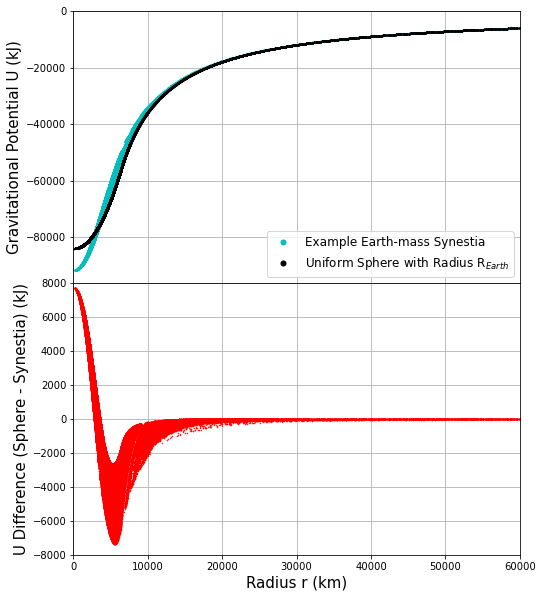

In [10]:
# stsm load canup 2012 results
SNAP_Canup=Snapshot()
SNAP_Canup.load('TE_Example01_Cool05_snapshot_4096_long',thermo=True) #Canup 2012 style giant impact


G = 6.67408e-11 #mks #gravitational constant
#M_Earth = np.sum(synfits.SNAP_Canup.m) #kg #Earth-mass synestia
#U_syn = synfits.SNAP_Canup.pot/1e3 #kJ #gravitational potential energy of synestia point cloud
#r_syn = np.sqrt(synfits.SNAP_Canup.x**2 + synfits.SNAP_Canup.y**2 + synfits.SNAP_Canup.z**2) #m
# stsm
M_Earth = np.sum(SNAP_Canup.m) #kg #Earth-mass synestia
U_syn = SNAP_Canup.pot/1e3 #kJ #gravitational potential energy of synestia point cloud
r_syn = np.sqrt(SNAP_Canup.x**2 + SNAP_Canup.y**2 + SNAP_Canup.z**2) #m

R_Earth = 6378137. #m #equatorial radius of present-day Earth
n = len(r_syn)
U_sphere = np.empty(n)
for i in range(n):
    if r_syn[i] < R_Earth:
        U_sphere[i] = 0.5*.001*G*M_Earth*(r_syn[i]**2 - 3.*(R_Earth**2))/(R_Earth**3) #kJ
    else:
        U_sphere[i] = -G*M_Earth/(r_syn[i]*1e3) #kJ
U_diff = U_sphere - U_syn #kJ

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(211)
plt.plot(r_syn/1e3, U_syn, 'c.', markersize=1, label='Example Earth-mass Synestia')
plt.plot(r_syn/1e3, U_sphere, 'k.', markersize=1, label='Uniform Sphere with Radius R$_{Earth}$')
plt.ylabel('Gravitational Potential U (kJ)', fontsize=15)
plt.ylim(ymax=0)
plt.xlim([0, 6e4])
ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.legend(loc=0, fontsize=12, markerscale=10)
plt.grid()
ax2 = fig.add_subplot(212, sharex = ax)
plt.plot(r_syn/1e3, U_diff, 'r.', markersize=1)
plt.xlabel('Radius r (km)', fontsize=15)
plt.ylabel('U Difference (Sphere - Synestia) (kJ)', fontsize=15)
plt.ylim([-8e3, 8e3])
plt.grid()
plt.subplots_adjust(hspace=0)
plt.show()
plt.close()

<i>Caption</i>. The difference in the gravitational potential energy profile between an Earth-mass synestia (cyan) and a perfect sphere of radius R$_{Earth}$ (black) with the same mass. A synestia has lower (less negative) gravitational potential energy than a uniform sphere at greater radii (r $>$ 3,000 km or outside the synestia's core), while the converse is true at lower radii.

You'll notice there are subtle deviations in the gravitational potential field of a synestia from that a sphere outside a spherical body and the planet-like region of a synestia. In the disk-like region of a synestia, gravitational potential energy is slightly greater (more negative) for a perfect sphere than it is for a synestia at larger radii. The disk-like region, where the angular velocity profile is no longer constant with radius, has a radius r $>$ 10,000 km in this example case. A synestia has mass distributed throughout its disk-like region, whereas an equivalent sphere does not. All the mass in a sphere is interior (between the observed location and the center of the body) to the disk-like region because this is a region located outside the body of an equivalent sphere. At a location in the disk-like region, there is an inward gravitational attraction towards the center of the sphere where all its mass concentrates. In a synestia, there is both inward- (toward the center of the body) and outward- (away from the center of the body) directed gravitational attraction to the surrounding mass at a location in the disk-like region. A point in the disk-like region of a synestia is still within the body of a synestia; there is mass interior and exterior (the observed location is between mass and the center of the body) to the point. There is less exterior mass, so the net gravitational force points inwards. There is nevertheless individual gravitational attraction to mass away from the center and there are sparser concentrations of mass in the disk-like region, so the magnitude of gravitational potential energy is lower than near the center of a synestia.

In the planet-like region of a synestia, the gravitational potential energy  of a perfect sphere is weaker (less negative) than a synestia at smaller radii spanning a synestia's core (r $<$ 3,000 km in the plot above). There is a substantial difference in the gravitational potential energy at the center of the bodies. A synestia's dense core has greater gravitational pull than that of an equivalent sphere. Within the planet-like region of a synestia, at larger radii spanning the mantle region (3,000 km $>$ r $>$ 10,000 km in the plot above), a sphere's gravitational potential energy is greater (more negative) than that of a synestia. The difference is substantial at the transition from a synestia's upper mantle to its lower mantle (5,000 km in the plot above). The mantle of a synestia is oblate due to a synestia's rapid rotation, so it is less dense. Due to sparser concentrations of mass in the mantle of a synestia, there is not as strong of a gravitational pull in a synestia's mantle compared to the same region in a sphere.

For a synestia, gravitational acceleration is much stronger along the midplane than it is off the midplane. The extra gravitational pull arises from the oblate structure of a synestia, which places more mass on the midplane than at at the poles. A synestia is very flared and has a disk-like shape away from its center. Its interior is spinning very rapidly, causing mass along the midplane to bulge out. The contribution this bulge, or oblateness, has on the gravitational field is what is called the second-order gravity term, or <i>J$_2$ term</i>.

The first-order term (1/r) of the gravitational acceleration that a particular body exerts on other objects is largely affected by the radius (how far the mass extends out from its center) of that body. At any point inside the sphere, the gravitational pull depends on how much mass is at larger radii compared to how much mass is at smaller radii. However, the second-order term (1/r$^3$) is largely affected by the mass distribution within that body, namely, along the midplane (z = 0, i.e. equator if you're thinking about Earth). Let's take a look below at the equation for the gravitational potential energy U of a synestia:

$$U(r) = -\frac{GM}{r}\left(1 - \frac{J_2a_{eq}^2}{2r^2}\left(\frac{3z^2}{r^2} - 1\right)\right)$$

For comparison, for a uniform sphere of radius R and mass M, the gravitational potential energy U is:

$$U(r) =
\begin{cases}
    -\frac{GM}{r}, & r\geq R\\
    -\frac{GM}{2R^3}(r^2 - 3R^2), & r < R
\end{cases}
$$

The J$_2$ term will be strongest near the midplane (z = 0) and at cylindrical radii where r$_{xy}$/z $> \sqrt{2}$. G is the gravitational constant, M is the total mass of the body, r is the distance between the origin and the position of a particle in 3-D (xyz) space, a$_{eq}$ is the equatorial radius of the body, and J$_2$ is a unitless number from 0 to 1 that depends on how spherical the mass distribution is. The more spherical the body is, the smaller J$_2$ will be. If the body is more squashed, bulging, or oblate, J$_2$ will be larger. For reference, Earth is nearly spherical with a J$_2$ of 0.001083; Earth's equatorial radius is ever so slightly larger than its polar radius due to its rotation.

However, changing the mass distribution within a body will also affect J$_2$. It is possible to have two bodies with the same oblateness, but different J$_2$ values (see image below). Say there is one body of uniform density and the other body is split into a denser central region (like a core) and a less dense outer region (like a mantle). The uniform density spheroid will have a larger J$_2$ than the body with a varying density distribution (more mass concentrated near the center of the body).

![FigureJ2.png](Figures/FigureJ2.png)

<i>Caption</i>. The J$_2$ gravity term affects both the oblateness and mass distribution of a synestia. A body with a given mass, rotation, and mean density can be oblate but either have most of its mass concentrated at its center (ex. dense core and low density atmosphere) with a low J$_2$ (left) or have a uniform density throughout so that extended parts of the body have more mass, or higher J$_2$ (right). Credit: G. O. Hollyday.

## Takeaways

Synestias exist in a temperature, pressure, and density regime that we are unfamiliar with. Synestias are very hot and their liquid-vapor interiors experience a wide range of pressures and densities. Rocky materials in this extreme thermal regime will behave as continuous fluids and experience tremendous pressure gas drag as liquids or support as vapor. The thermodynamics of a planet-disk system do not apply to a synestia. The hot, turbulent thermal history of a synestia will contribute to the evolution of the interior dynamics of its resultant planet.

Due to the rapid rotation of the planet-like region within a synestia, a synestia is very oblate. A synestia is axis-symmetric about its rotational axis. A synestia's mass distribution is different from that of a planet; more mass exists at the equator far from the center of the synestia (less mass is concentrated towards the center of the body). This aids moon formation in a synestia as it supplies more material to the moon-forming region. The oblate gravity field of a synestia also affects the orbits of rain and moonlets inside a synestia, which can aid or hurt lunar accretion (to be explored in Jupyter Notebook 5: Forces Acting Within Synestias).

## References

Carter, P. J., Lock, S. J., & Stewart, S. T. (2020). The Energy Budgets of Giant Impacts. <i>Journal of Geophysical Research: Planets (American Geophysical Union)</i>, 125 (1), 1-18.

U.S. Energy Information Administration. (2015). <i>Consumption and Expenditures Table 1.1 Summary consumption and expenditures in the U.S. - totals and intensities</i>. 2015 Residential Energy Consumption Survey Data. Retrieved from https://www.eia.gov/consumption/residential/data/2015/c&e/pdf/ce1.1.pdf (EIA)